2022-02-26 11:18:32.458947: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


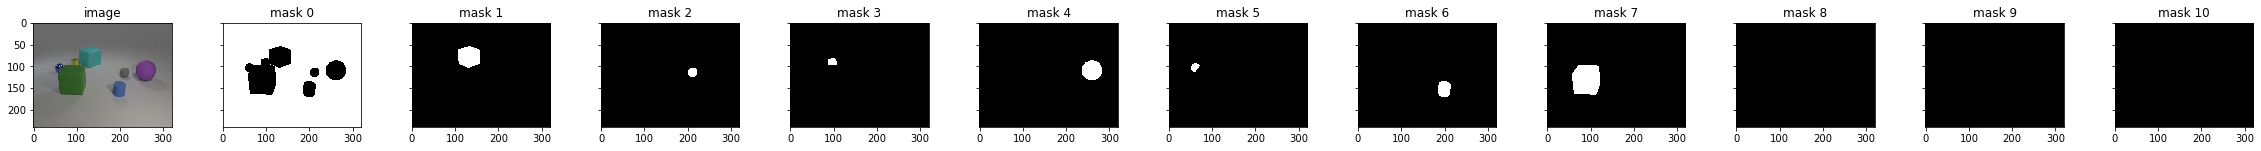

,visibility,x,y,z,pixel_coords,rotation,size,material,shape,color
0,True,0.000000,0.000000,0.00,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0.000000,0,0,0,0
1,True,-2.365707,0.625255,0.70,"(tf.Tensor(131.0, shape=(), dtype=float32), tf...",171.261490,1,1,3,2
2,True,1.269057,1.046907,0.35,"(tf.Tensor(211.0, shape=(), dtype=float32), tf...",107.751411,2,1,1,6
3,True,-2.606125,-0.709509,0.35,"(tf.Tensor(98.0, shape=(), dtype=float32), tf....",229.034058,2,2,2,8
4,True,2.504530,1.830275,0.70,"(tf.Tensor(260.0, shape=(), dtype=float32), tf...",177.685455,1,1,1,7
5,True,-2.638200,-2.151204,0.35,"(tf.Tensor(61.0, shape=(), dtype=float32), tf....",260.119873,2,2,1,4
6,True,2.618906,-0.962137,0.35,"(tf.Tensor(199.0, shape=(), dtype=float32), tf...",320.096649,2,1,2,4
7,True,0.346145,-2.732890,0.70,"(tf.Tensor(92.0, shape=(), dtype=float32), tf....",22.800489,1,1,3,3
8,False,0.000000,0.000000,0.00,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0.000000,0,0,0,0
9,False,0.000000,0.000000,0.00,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0.000000,0,0,0,0


In [1]:
import logging
from functools import partial
from itertools import product
from operator import itemgetter
from pathlib import Path
from typing import Tuple

import einops
import matplotlib.pyplot as plt
import multi_object_datasets.clevr_with_masks
import numpy as np
import pandas as pd
import PIL.Image as PilImage
import scipy.optimize
import skimage.filters
import skimage.morphology
import tensorflow as tf
import torch.nn.functional
import tqdm
from einops import rearrange, reduce
from IPython.display import JSON, Image, Markdown, display, display_html
from matplotlib.ticker import PercentFormatter
from omegaconf import OmegaConf
from osc.data.clevr_with_masks import IMAGE_SIZE, fix_tf_dtypes, show_sample
from osc.data.utils import normalize_tf, unnormalize_pt
from osc.models.embeds import PositionalEmbedding
from osc.models.models import forward_with_attns
from osc.train import (
    build_dataset_vqa,
    build_linear_probe,
    build_model,
    extract_vqa_features,
    run_test_linear_probes,
)
from osc.utils import latest_checkpoint, print_arrays
from osc.viz.attentions import viz_slot_attns, viz_vit_attns
from osc.viz.backbone import kmeans_backbone
from osc.viz.embeds import viz_positional_embedding
from osc.viz.loss_global import viz_contrastive_loss_global
from osc.viz.loss_objects import (
    viz_contrastive_loss_objects,
    viz_contrastive_loss_objects_probs,
)
from osc.viz.rollout import self_attn_rollout, slot_attn_rollout
from osc.viz.utils import (
    array_to_pil,
    batched_otsu,
    batched_otsu_pt,
    fig_save_display,
    img_html,
    subplots_grid,
    text_html,
)
from osc.wandb_utils import find_run_by_name
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    average_precision_score,
    roc_auc_score,
)
from tabulate import tabulate
from torchvision.transforms.functional import to_pil_image

logging.basicConfig(level="INFO")

tfr_path = Path.home() / "multi-object-datasets/clevr_with_masks/imgs_test.tfrecords"

ds = tf.data.TFRecordDataset(tfr_path.as_posix(), compression_type="GZIP")
ds = ds.map(multi_object_datasets.clevr_with_masks._decode)
ds = ds.map(fix_tf_dtypes)
sample = ds.take(1).get_single_element()
show_sample(sample)

## Setup

Config

In [2]:
wandb_run_id = "zen-babbage-00"
# wandb_run_id = "agitated-roentgen-17" # global only
outputs_dir = Path("../outputs")
run_dir = outputs_dir / find_run_by_name(wandb_run_id, outputs_dir)
print(run_dir)

cfg = OmegaConf.load(run_dir / "train.yaml")
display(JSON(OmegaConf.to_container(cfg, resolve=True)))

cfg.other.device = "cuda:0"
cfg.other.tqdm = True

num_patches = np.array(cfg.data.crop_size) // np.array(cfg.model.backbone.patch_size)

../outputs/2022-02-19/13-26-34


<IPython.core.display.JSON object>

Checkpoint

In [3]:
model = build_model(cfg)
checkpoint = torch.load(latest_checkpoint(run_dir), map_location="cpu")
model.load_state_dict(checkpoint["model"])
model.to(cfg.other.device)
model.eval()
del checkpoint

Test batch

INFO:osc.train:Dataset test VQA, 15000 samples, 8 batch size, 1875 batches


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


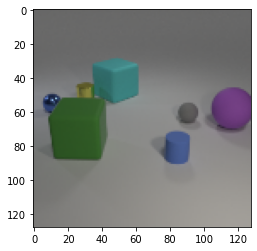

In [4]:
ds = build_dataset_vqa(cfg)
_, example = ds.take(1).get_single_element()
image = torch.from_numpy(example["image"][0].numpy())

fig, ax = plt.subplots(1, 1)
ax.imshow(
    to_pil_image(
        unnormalize_pt(
            image,
            mean=tuple(cfg.data.normalize.mean),
            std=tuple(cfg.data.normalize.std),
        )
    )
)
print(example["vqa_target"][0].numpy().astype(int))

VQA f    0: 100% 15000/15000, 02:10<00:00, 115.18img/s


Adjust positive class? None


100% 1000/1000 [00:04<00:00, 218.03it/s]


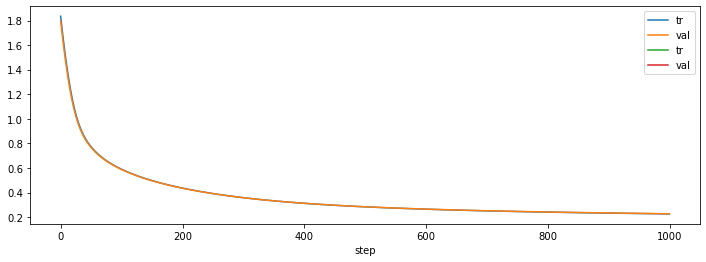

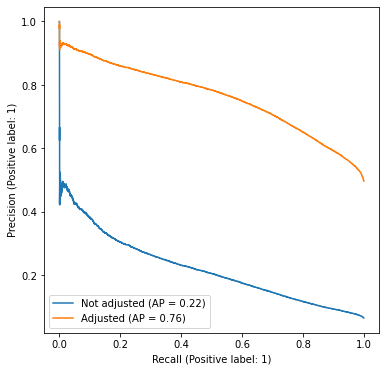

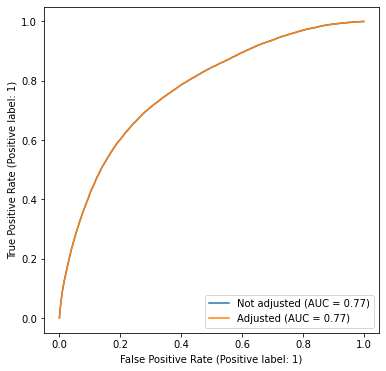

0.2141252539768895 0.7539491449052357
Adjust positive class? tensor(14.)


100% 1000/1000 [00:04<00:00, 215.24it/s]


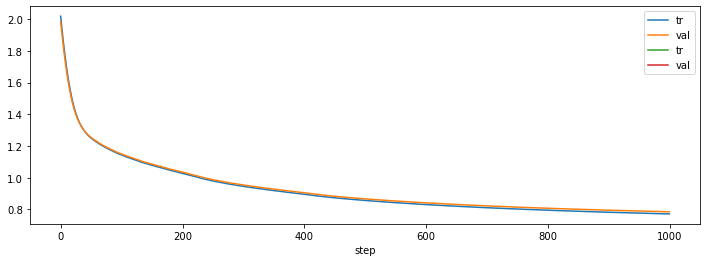

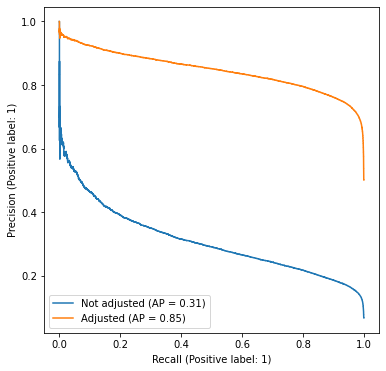

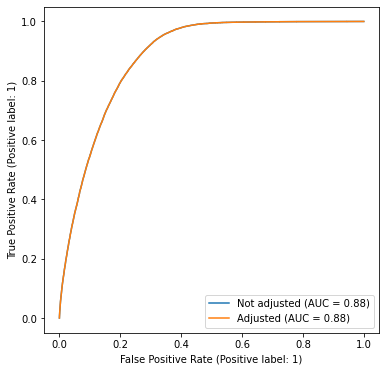

0.30168519364638124 0.8663954159137348


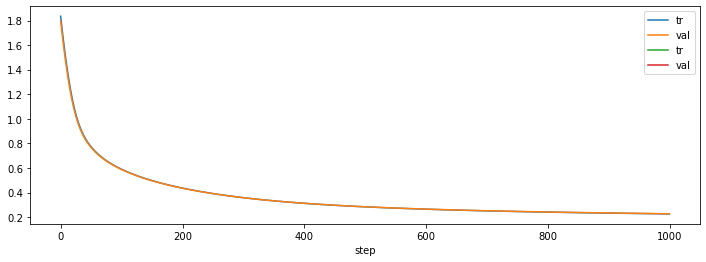

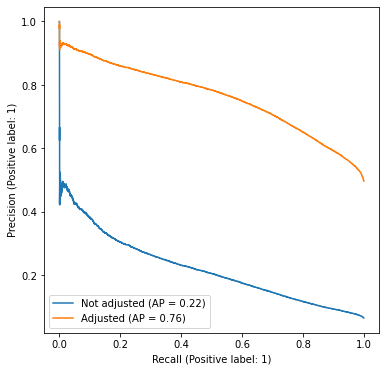

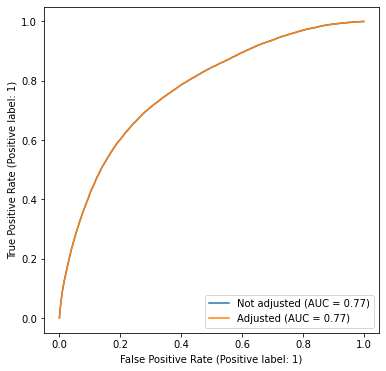

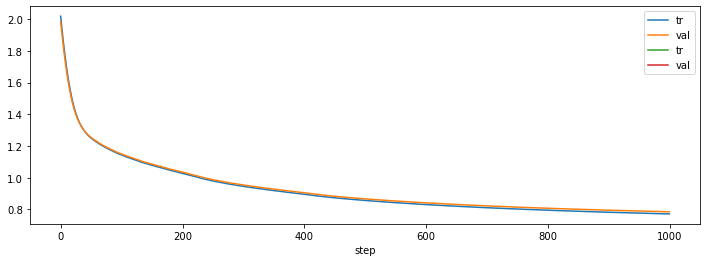

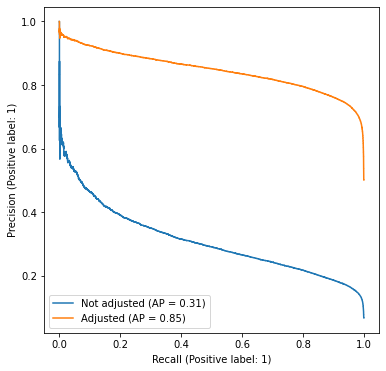

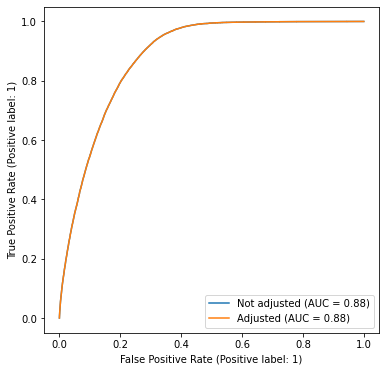

In [5]:
features, targets = extract_vqa_features(cfg, ds, 0, model)

for pos_weight in [None, torch.tensor(14.0)]:
    print("Adjust positive class?", pos_weight)

    split = int(0.75 * len(features))
    features_train = features[:split].to(cfg.other.device)
    features_test = features[split:].to(cfg.other.device)
    targets_train = targets[:split].float().to(cfg.other.device)
    targets_test = targets[split:].float().to(cfg.other.device)

    torch.manual_seed(0)
    probe = build_linear_probe(cfg, targets.shape[-1]).to(cfg.other.device)
    optimizer = torch.optim.AdamW(probe.parameters())

    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    hist = []
    for i in tqdm.trange(1000, ncols=0):
        optimizer.zero_grad()
        preds = probe(features_train)
        loss = loss_fn(preds.flatten(), targets_train.flatten())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            preds = probe(features_test)
            loss_v = loss_fn(preds.flatten(), targets_test.flatten())
            hist.append((i, loss.item(), loss_v.item()))

    with torch.no_grad():
        preds = probe(features_test)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(preds, targets_test)
        targets_test = targets_test.cpu().numpy().astype(bool)
        sample_weight = np.where(targets_test.flatten(), 14.0, 1.0)
        preds = preds.sigmoid_().cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    pd.DataFrame(hist, columns=["step", "tr", "val"]).set_index("step").plot(ax=ax)
    pd.DataFrame(hist, columns=["step", "tr", "val"]).set_index("step")[2500:].plot(
        ax=ax
    )
    fig.set_facecolor("white")
    display(fig)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    PrecisionRecallDisplay.from_predictions(
        y_true=targets_test.flatten(),
        y_pred=preds.flatten(),
        ax=ax,
        name="Not adjusted",
    )
    PrecisionRecallDisplay.from_predictions(
        y_true=targets_test.flatten(),
        y_pred=preds.flatten(),
        sample_weight=sample_weight,
        ax=ax,
        name="Adjusted",
    )
    fig.set_facecolor("white")
    display(fig)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    RocCurveDisplay.from_predictions(
        y_true=targets_test.flatten(),
        y_pred=preds.flatten(),
        ax=ax,
        name="Not adjusted",
    )
    RocCurveDisplay.from_predictions(
        y_true=targets_test.flatten(),
        y_pred=preds.flatten(),
        sample_weight=sample_weight,
        ax=ax,
        name="Adjusted",
    )
    fig.set_facecolor("white")
    display(fig)

    ap = average_precision_score(y_true=targets_test, y_score=preds, average="weighted")
    auroc = roc_auc_score(y_true=targets_test, y_score=preds, average="weighted")
    print(ap, auroc)

In [16]:
pd.DataFrame(
    targets.cpu().numpy(),
    columns=pd.MultiIndex.from_product(
        [
            ["Large", "Small"],
            list("ABCDEFGH"),
            ["Metal", "Rubber"],
            ["Cube", "Sphere", "Cylinder"],
        ],
        names=("Size", "Color", "Material", "Shape"),
    ),
).mean().unstack("Color").style.format(lambda v: f"{100*v:.1f}")

## Examples
Forward pass test batch

In [39]:
ds_probe = {
    "obj_features": [],
    "global_features": [],
    "vqa_targets": [],
}

with torch.no_grad():
    for examples in tqdm.tqdm(
        ds.map(
            lambda example: foo(
                example,
                img_size=IMAGE_SIZE,
                crop_size=tuple(cfg.data.crop_size),
                mean=tuple(cfg.data.normalize.mean),
                std=tuple(cfg.data.normalize.std),
            ),
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=True,
        )
        # .take(320)
        .batch(32, drop_remainder=False).as_numpy_iterator(),
        unit_scale=32,
    ):
        images = torch.from_numpy(examples["image"])
        vqa_targets = torch.from_numpy(examples["vqa_targets"])
        output = model(images.to(cfg.other.device))
        ds_probe["obj_features"].append(output.f_slots.cpu())
        ds_probe["global_features"].append(output.f_global.cpu())
        ds_probe["vqa_targets"].append(vqa_targets)

ds_probe = {
    k: torch.cat(v, dim=0).to(cfg.other.device).float() for k, v in ds_probe.items()
}
print_arrays(ds_probe)

15008it [02:28, 101.07it/s]


name             dtype          shape
---------------  -------------  ---------------
obj_features     torch.float32  [15000, 11, 64]
global_features  torch.float32  [15000, 64]
vqa_targets      torch.float32  [15000, 8]


In [41]:
from itertools import chain

from einops.layers.torch import Reduce

probe_global = torch.nn.Linear(cfg.model.backbone.embed_dim, 8).to(cfg.other.device)
probe_objects = torch.nn.Sequential(
    torch.nn.Linear(cfg.model.backbone.embed_dim, 8),
    Reduce("B S C -> B C", reduction="max"),
).to(cfg.other.device)
optimizer = torch.optim.AdamW(
    chain(probe_global.parameters(), probe_objects.parameters())
)

for i in range(2000):
    optimizer.zero_grad()

    preds_global = probe_global(ds_probe["global_features"][:10000])
    loss_global = torch.nn.functional.binary_cross_entropy_with_logits(
        preds_global,
        ds_probe["vqa_targets"][:10000],
    )
    loss_global.backward()

    preds_objects = probe_objects(ds_probe["obj_features"][:10000])
    loss_objects = torch.nn.functional.binary_cross_entropy_with_logits(
        preds_objects,
        ds_probe["vqa_targets"][:10000],
    )
    loss_objects.backward()

    optimizer.step()

    if i % 200 == 0 or i + 1 == 2000:
        print(i)
        with torch.no_grad():
            preds_global = probe_global(ds_probe["global_features"][10000:])
            loss_global_val = torch.nn.functional.binary_cross_entropy_with_logits(
                preds_global,
                ds_probe["vqa_targets"][10000:],
            )
            accuracy = torch.mean(
                ((preds_global > 0) == ds_probe["vqa_targets"][10000:]).float(), dim=0
            )
            print("global", loss_global.item(), loss_global_val.item())
            print(accuracy.mul(100).cpu().numpy().round(1))
            print()

            preds_objects = probe_objects(ds_probe["obj_features"][10000:])
            loss_objects_val = torch.nn.functional.binary_cross_entropy_with_logits(
                preds_objects,
                ds_probe["vqa_targets"][10000:],
            )
            accuracy = torch.mean(
                ((preds_objects > 0) == ds_probe["vqa_targets"][10000:]).float(), dim=0
            )
            print("objects", loss_objects.item(), loss_objects_val.item())
            print(accuracy.mul(100).cpu().numpy().round(1))
            print()

0
global 0.7004586458206177 0.6937848925590515
[58.1 45.9 65.5 42.7 62.6 50.2 57.6 38.7]

objects 0.6965914368629456 0.6922410130500793
[58.4 56.7 56.2 57.  55.2 56.2 56.5 55.7]

200
global 0.26815223693847656 0.26923906803131104
[95.7 96.6 97.8 95.9 88.  88.4 94.3 93.3]

objects 0.26665419340133667 0.26668182015419006
[97.7 99.3 97.2 98.9 87.3 90.  97.1 94. ]

400
global 0.18887174129486084 0.1902545839548111
[97.1 97.6 98.2 97.1 88.8 89.8 96.2 93.9]

objects 0.18562979996204376 0.1862471103668213
[97.4 99.5 98.1 99.  89.1 92.2 97.2 94.6]

600
global 0.156329944729805 0.15776027739048004
[97.7 98.  98.5 97.6 89.2 90.5 97.2 94.1]

objects 0.1502128392457962 0.15093344449996948
[97.5 99.4 98.4 99.  89.6 92.2 97.9 94.9]

800
global 0.13874170184135437 0.14020493626594543
[97.9 98.3 98.6 97.9 89.3 90.8 97.6 94.2]

objects 0.13079482316970825 0.1315128356218338
[97.6 99.4 98.4 99.  90.  92.5 98.2 95.3]

1000
global 0.12783342599868774 0.1293284296989441
[98.  98.4 98.8 98.  89.4 91.  97.8 